Seasonal climate anomalies in ERA Interim preceding the 2018 wildfire season in the western U.S., and correlations between monthly burned area & climate.


In [222]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import xesmf as xe
import gcsfs
import cartopy.crs as ccrs
import cartopy
import regionmask
from pyproj import Proj, Transformer, CRS
import geopandas
import rioxarray
from shapely.geometry import mapping
import seaborn as sns
g = 9.80665
%matplotlib inline
import scipy.stats as stats
import pandas as pd

def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

def fix_coords(ds):
    ds = ds.assign_coords(X=(((ds.X + 180) % 360) - 180)).sortby(['X','Y']).rename({'X':'lon','Y':'lat'})
    return ds

period= slice('2017-12-16','2018-11-16')
period1 = slice('2016-12-16','2017-11-16')
period_burn = slice('2018-06-15','2018-11-15')
seasons = ['DJF','MAM','JJA','SON']

In [101]:
import cftime
def to_dt64(ds, timevar='T', unit='months since 1979-01-01'):
    ds[timevar] = cftime.num2date(ds[timevar], unit, '360_day')
    ds[timevar] = ds.indexes[timevar].to_datetimeindex()
    return ds

In [1068]:
#!wget -O u.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.u.nc/data.cdf
#!wget -O v.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.v.nc/data.cdf
#!wget -O w.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.w.nc/data.cdf
#!wget -O z.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.z.nc/data.cdf

#!wget -O u10.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.u10.nc/data.cdf
#!wget -O v10.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.v10.nc/data.cdf
#!wget -O t2m.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.t2m.nc/data.cdf
#!wget -O d2m.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.d2m.nc/data.cdf
#!wget -O sst.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.sst.nc/data.cdf
#!wget -O sp.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Surface/.sp.nc/data.cdf


#!wget -O tp.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Accum/.tp.nc/data.cdf
#!wget -O evap.cdf http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.Accum/.evap.nc/data.cdf


--2021-02-08 15:59:53--  http://kage.ldeo.columbia.edu:81/home/.datasets/.ERAInterim/.monthly/.PressureLevels/.q.nc/data.cdf
Resolving kage.ldeo.columbia.edu... 129.236.21.133
Connecting to kage.ldeo.columbia.edu|129.236.21.133|:81... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2035082472 (1.9G) [application/x-netcdf]
Saving to: ‘q.cdf’

q.cdf               100%[===================>]   1.89G  34.0MB/s    in 52s     

2021-02-08 16:01:01 (37.2 MB/s) - ‘q.cdf’ saved [2035082472/2035082472]



In [1287]:
# load in single-level data as a single dataset 
ds1979 = xr.open_mfdataset(['swvl1.cdf','swvl2.cdf','swvl3.cdf', 'swvl4.cdf',
                        'u10.cdf','v10.cdf','sst.cdf','d2m.cdf','t2m.cdf','sp.cdf'],decode_times=False,chunks={'T' : 1})
ds1960 = xr.open_mfdataset(['tp.cdf','evap.cdf'],decode_times=False,chunks={'T' : 1})

# for some reason open_mfdataset is breaking with more than ^ many variables, messes up time,
# so load in extras here
#d2m = xr.open_dataset('d2m.cdf',decode_times=False)
#t2m = xr.open_dataset('t2m.cdf',decode_times=False)


# get single pressure level for pressure data and add to ds
u700 = xr.open_dataset('u.cdf',decode_times=False).sel(P=700).rename({'u':'u700'}).drop('P')
v700 = xr.open_dataset('v.cdf',decode_times=False).sel(P=700).rename({'v':'v700'}).drop('P')
w700 = xr.open_dataset('w.cdf',decode_times=False).sel(P=700).rename({'w':'w700'}).drop('P')
z200 = xr.open_dataset('z.cdf',decode_times=False).sel(P=200).rename({'z':'z200'}).drop('P')/g
z500 = xr.open_dataset('z.cdf',decode_times=False).sel(P=500).rename({'z':'z500'}).drop('P')/g
z700 = xr.open_dataset('z.cdf',decode_times=False).sel(P=700).rename({'z':'z700'}).drop('P')/g


datasets = [to_dt64(ds1979), to_dt64(ds1960, unit = 'months since 1960-01-01'), to_dt64(u700),
            to_dt64(v700),to_dt64(w700), to_dt64(z200),to_dt64(z500),to_dt64(z700)]
ds = xr.merge(datasets)

# fix time, coords
#ds = fix_coords(xr.decode_cf(fix_calendar(ds)))
ds = fix_coords(ds)

# calculate VPD and add to dataset
es0 = 6.11 #mb
c1 = 17.67 
T0 =  273.15 #K
es_a = es0*np.exp(c1*(ds.t2m - T0)/(ds.t2m - T0 + 243.5))
ea = es0*np.exp(c1*(ds.d2m - T0)/(ds.d2m - T0 + 243.5))
VPD = es_a - ea
VPD.attrs['units'] = 'mbar'
ds['VPD'] = VPD

# calculate surface specific humidity (q) and add to dataset
# https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
# q \approx 0.622*e / (p−0.378e)
MwMd = 0.622
qs = (MwMd*ea)/(ds.sp - 0.378*ea)
qs.attrs['units'] = 'kg/kg'
ds['qs'] = qs

# calculate soil moisture volume and add to dataset
soil_depths = [0.07, (7-28)*-0.01, (28-100)*-0.01, (100-289)*-0.01]
oldnames = ['swvl1','swvl2','swvl3','swvl4']
sm_anoms_s_renamed = [anom_s[oldnames[i]] for i in range(len(soil_depths))]
ds['swv'] = sum([x*y for x,y in zip(sm_anoms_s_renamed,soil_depths)])
ds.swv.attrs['units'] = 'm**3/m**2'

# fix units where necessary
# m/s to mm/day
ds['tp'] = 8.64e+7*ds.tp
ds.tp.attrs['units'] = 'mm/day'

# m/s to mm/day, make evap positive
ds['evap'] = -1*8.64e+7*ds.evap
ds.evap.attrs['units'] = 'mm/day'

/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


In [1078]:
# surface pressure in separate dataset (go from Pa to mb)
sp700 = xr.open_dataset('z.cdf',decode_times=False).sel(P=700)/100.
sp700 = fix_coords(to_dt64(sp700))

/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


In [1630]:
# burn area
burn = xr.open_dataset('burnarea_mtbs_only.nc',decode_times=False)
burn = xr.decode_cf(burn, decode_times = True)
burn = burn.sel(time = slice('1984-01-15','2018-12-15'))

# forest cover (max of each gridcell)
forest = xr.open_dataset('forest.nc').sel(year = slice(1984,2018))
forest = forest.assign_coords({'year':[int(x) for x in forest.year]})
forest = forest.max('year').forest

# set up burn & forest with rioxarray 
burn.rio.set_spatial_dims(x_dim="X", y_dim="Y", inplace=True)
burn.rio.write_crs("epsg:5070", inplace=True)
forest.rio.set_spatial_dims(x_dim="X", y_dim="Y", inplace=True)
forest.rio.write_crs("epsg:5070", inplace=True)

# burned forested area
burn_for = burn*forest

In [1631]:
# read california shape file
cali = geopandas.read_file('CA_State_TIGER2016.shp')

# mask burn with california shapefile
burn_cali = burn.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
burn_cali = burn_cali.sum(['X','Y'])

# same for forested burn
burn_for.rio.set_spatial_dims(x_dim='X',y_dim='Y',inplace=True)
burn_for_cali = burn_for.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
burn_for_cali = burn_for_cali.sum(['X','Y'])
burn_forlog_cali = xr.ufuncs.log10(burn_for_cali.burnarea + 0.01)


In [1288]:
#ds = ds.load()

# suppress the dask PerformanceWarning from calculating anomalies
#import warnings
#with warnings.catch_warnings():
#    warnings.simplefilter(action='ignore', category='PerformanceWarning')

# calculate 1979-2019 seasonal and monthly climatologies
clim_m = ds.groupby('T.month').mean()
clim_s = ds.groupby('T.season').mean()

# calculate seasonal and monthly anomalies
anom_m = ds.groupby('T.month') - clim_m
anom_s = ds.groupby('T.season') - clim_s

# calculate seasonal and monthly std
std_m = ds.groupby('T.month').std()
std_s = ds.groupby('T.season').std()

In [2026]:
var_m = ds.sel(T=slice('1983-01-16','2017-12-16')).groupby('T.month').var('T')

In [1947]:
# calculate seasonal and monthly vars
var_m = ds.groupby('T.month').var()
#var_s = ds.groupby('T.season').var()

In [2095]:
# set up california boundaries for climate vars
anom_s_cali = anom_s.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
anom_s_cali.rio.write_crs("epsg:4326", inplace=True)

anom_m_cali = anom_m.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
anom_m_cali.rio.write_crs("epsg:4326", inplace=True)

clim_m_cali = clim_m.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
clim_m_cali.rio.write_crs("epsg:4326", inplace=True)

std_m_cali = std_m.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
std_m_cali.rio.write_crs("epsg:4326", inplace=True)

# mask anom with cali shapefile
anom_m_cali = anom_m_cali.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
anom_s_cali = anom_s_cali.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
clim_m_cali = clim_m_cali.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)
std_m_cali = std_m_cali.rio.clip(cali.geometry.apply(mapping), cali.crs, drop=False)

## precipitation

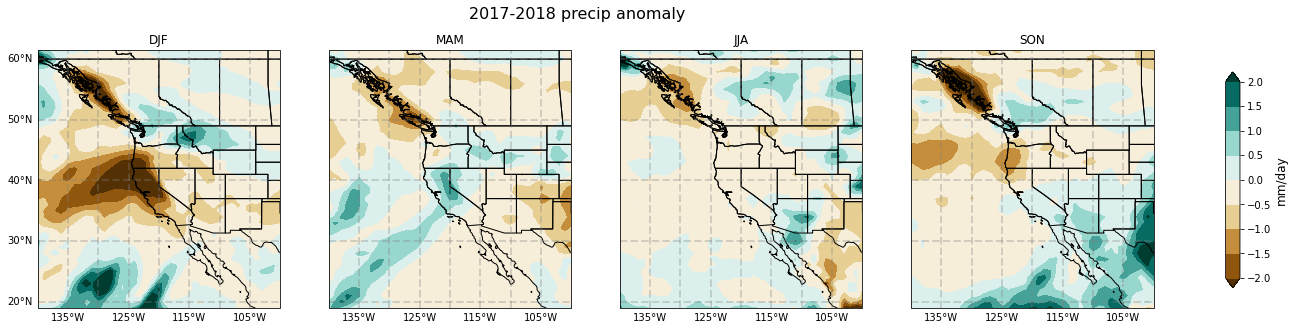

In [106]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = anom_s.tp.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('2017-2018 precip anomaly',fontsize=16);


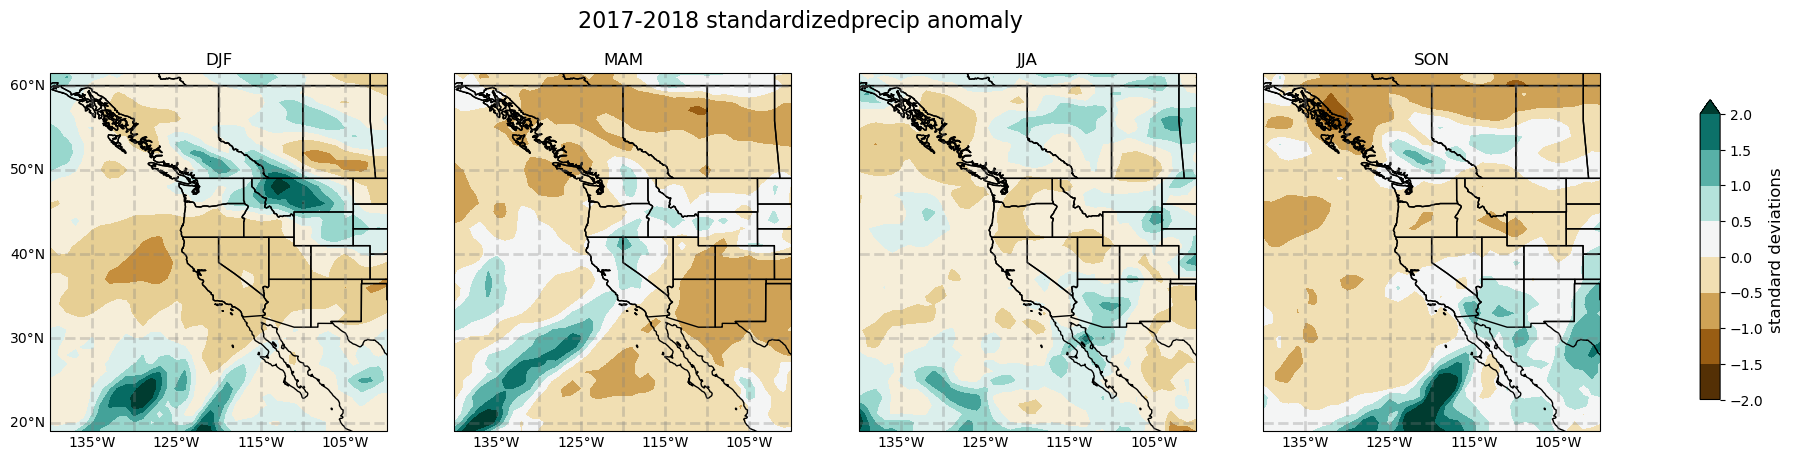

In [1996]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = (anom_s.tp.sel(T=period).groupby('season').mean() / std_s.tp).sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('2017-2018 standardized precip anomaly',fontsize=16);


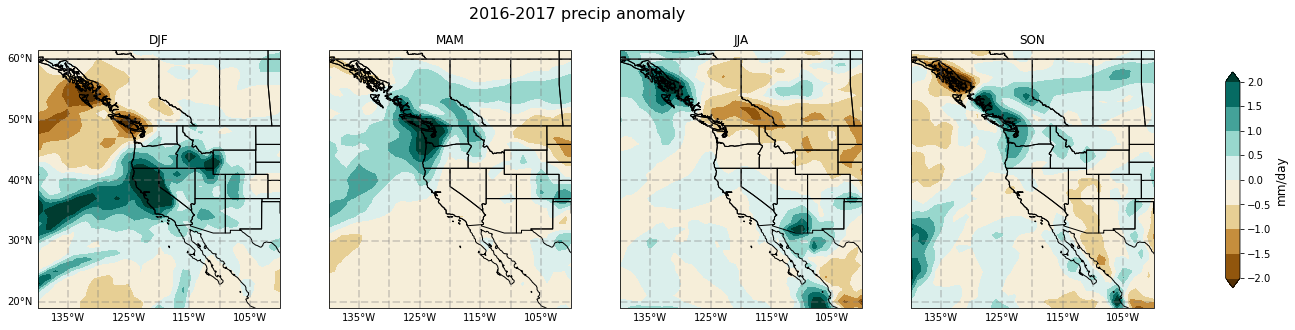

In [16]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = anom_s.tp.sel(T=period1).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2, vmax=2, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('2016-2017 precip anomaly',fontsize=16);


## evaporation

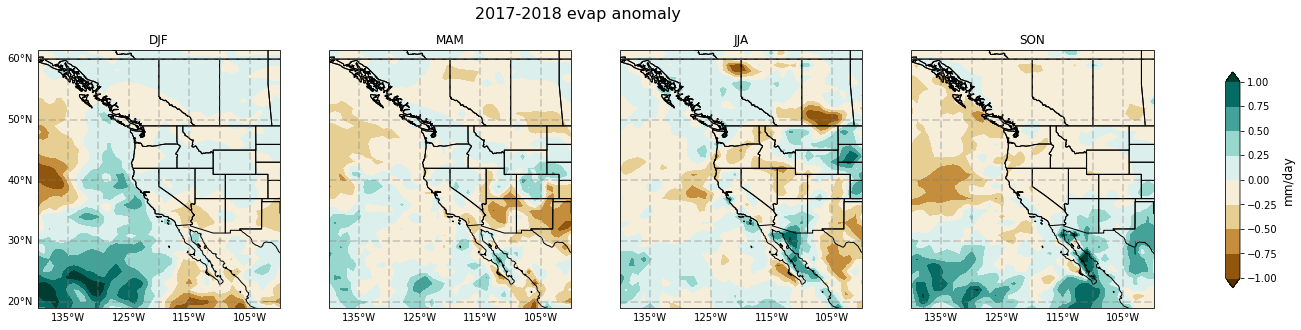

In [124]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = anom_s.evap.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-1, vmax=1, levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='mm/day',size=12)
plt.suptitle('2017-2018 evap anomaly',fontsize=16);


## soil moisture

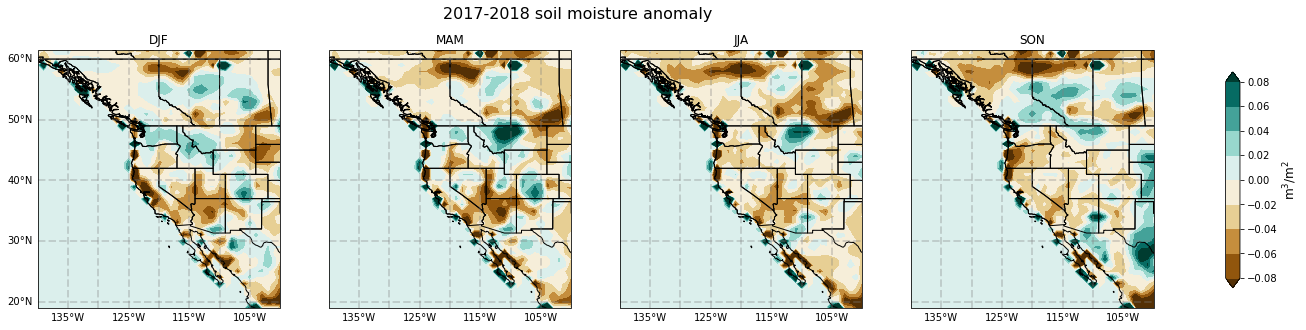

In [141]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = anom_s.swv.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-.08,vmax=0.08,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m$^3$/m$^2$',size=12)
plt.suptitle('2017-2018 soil moisture anomaly',fontsize=16);


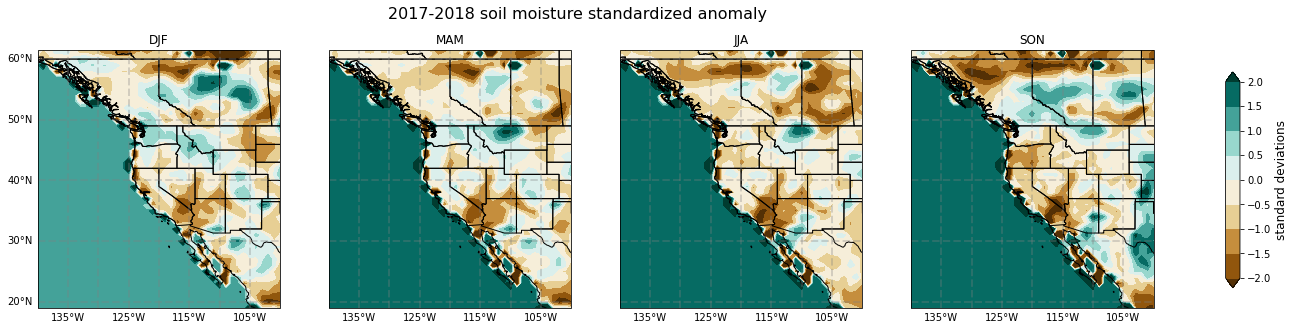

In [143]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = (anom_s.swv.sel(T=period).groupby('season').mean()/std_s.swv).sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2,vmax=2,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('2017-2018 soil moisture standardized anomaly',fontsize=16);


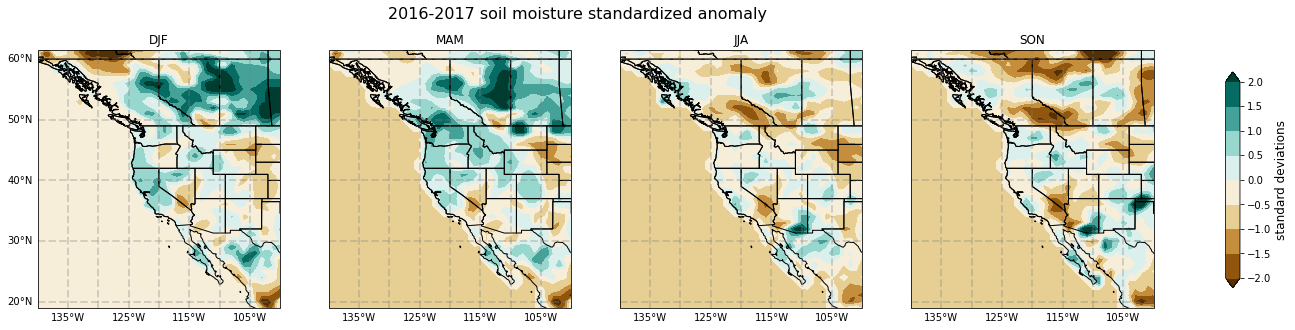

In [144]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
extent = [-140, -100, 19, 60]
seasons=['DJF','MAM','JJA','SON']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(1,4,i+1,projection=ccrs.PlateCarree())
    im = (anom_s.swv.sel(T=period1).groupby('season').mean()/std_s.swv).sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2,vmax=2,levels=9, cmap='BrBG',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i>0:
        gl.left_labels=False
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.01,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('2016-2017 soil moisture standardized anomaly',fontsize=16);


## 2 meter temperature and VPD

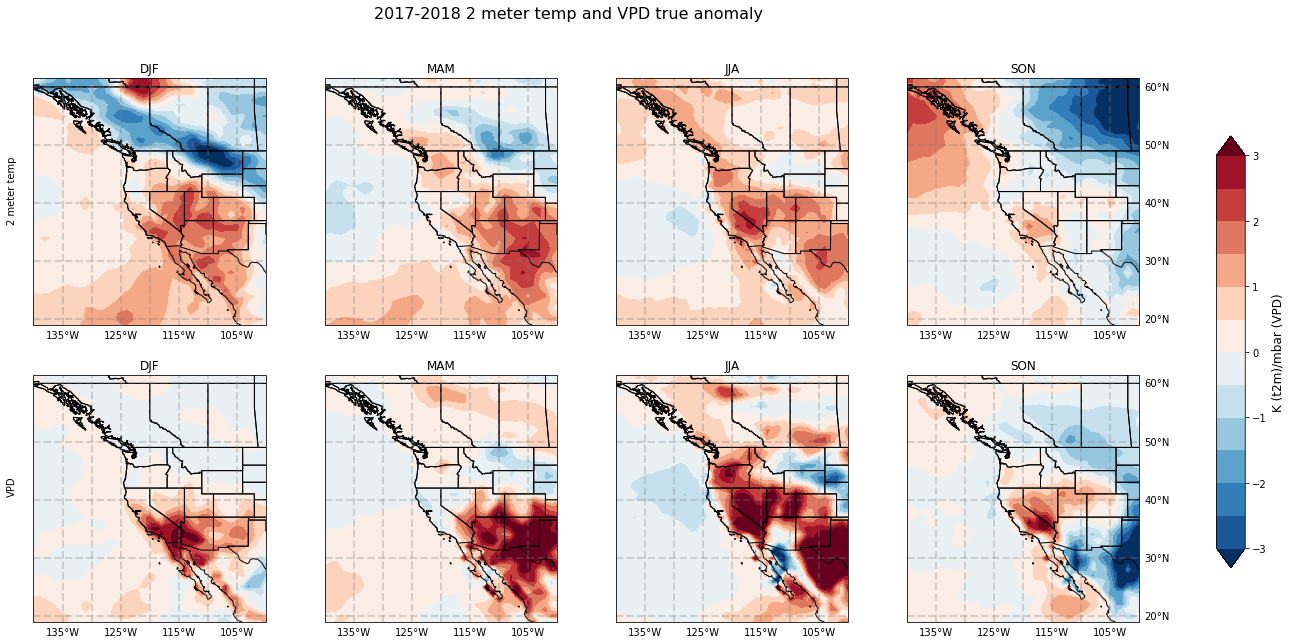

In [115]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,4,i+1,projection=ccrs.PlateCarree())
    if i<4:
        im = anom_s.t2m.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
            ax=ax, vmin=-3, vmax=3,levels=13, cmap='RdBu_r',add_colorbar=False)
    else:
        im = anom_s.VPD.sel(T=period).groupby('season').mean().sel(season=seasons[i-4]).plot.contourf(
            ax=ax, vmin=-3, vmax=3,levels=13, cmap='RdBu_r',add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i==3 or i==7:
        gl.right_labels=True
    else:
        gl.right_labels=False
    gl.top_labels = False
    gl.left_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i-4])
    ax.set_ylabel('test')
    if i==0:
        ax.text(-0.07, 0.55, '2 meter temp', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
    if i==4:
        ax.text(-0.07, 0.55, 'VPD', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='K (t2m)/mbar (VPD)',size=12)
plt.suptitle('2017-2018 2 meter temp and VPD true anomaly',fontsize=16);


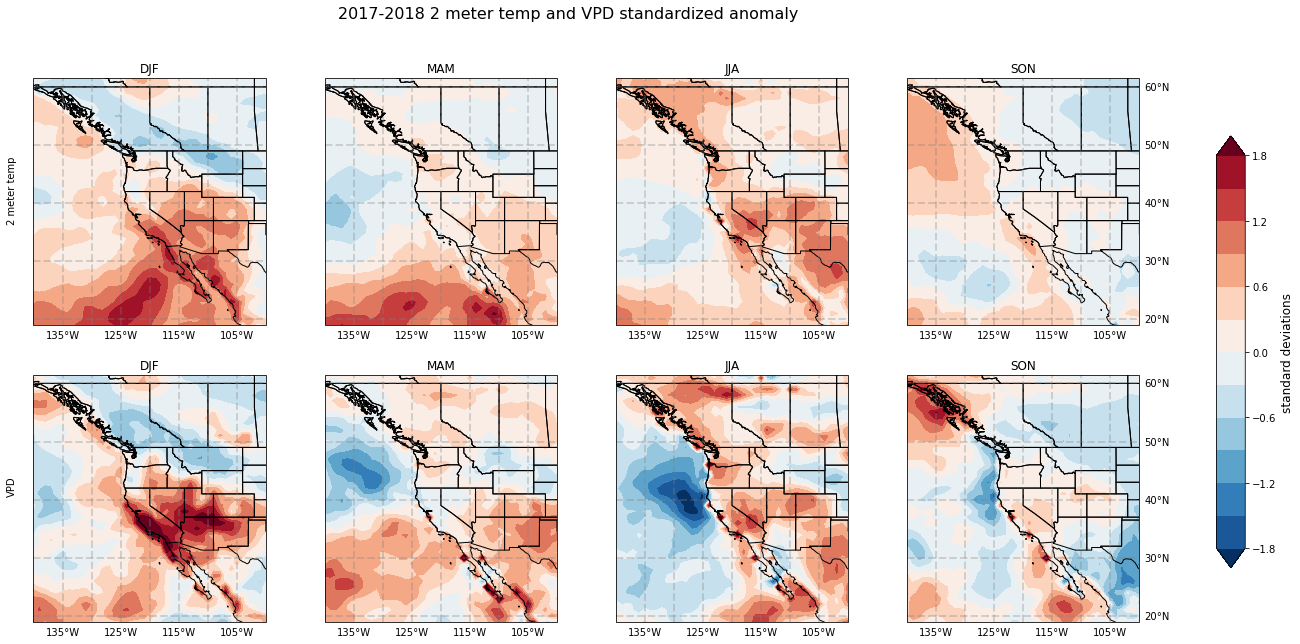

In [7]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,4,i+1,projection=ccrs.PlateCarree())
    if i<4:
        im = (anom_s.t2m.sel(T=period).groupby('season').mean() / std_s.t2m).sel(season=seasons[i]).plot.contourf(
            ax=ax, vmin=-1.8, vmax=1.8,levels=13, cmap='RdBu_r',add_colorbar=False)
    else:
        im = (anom_s.VPD.sel(T=period).groupby('season').mean() / std_s.VPD).sel(season=seasons[i-4]).plot.contourf(
            ax=ax, vmin=-1.8, vmax=1.8,levels=13, cmap='RdBu_r',add_colorbar=False)    
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    if i==3 or i==7:
        gl.right_labels=True
    else:
        gl.right_labels=False
    gl.top_labels = False
    gl.left_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i-4])
    ax.set_ylabel('test')
    if i==0:
        ax.text(-0.07, 0.55, '2 meter temp', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
    if i==4:
        ax.text(-0.07, 0.55, 'VPD', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='standard deviations',size=12)
plt.suptitle('2017-2018 2 meter temp and VPD standardized anomaly',fontsize=16);

## winds and vertical velocity

/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vec

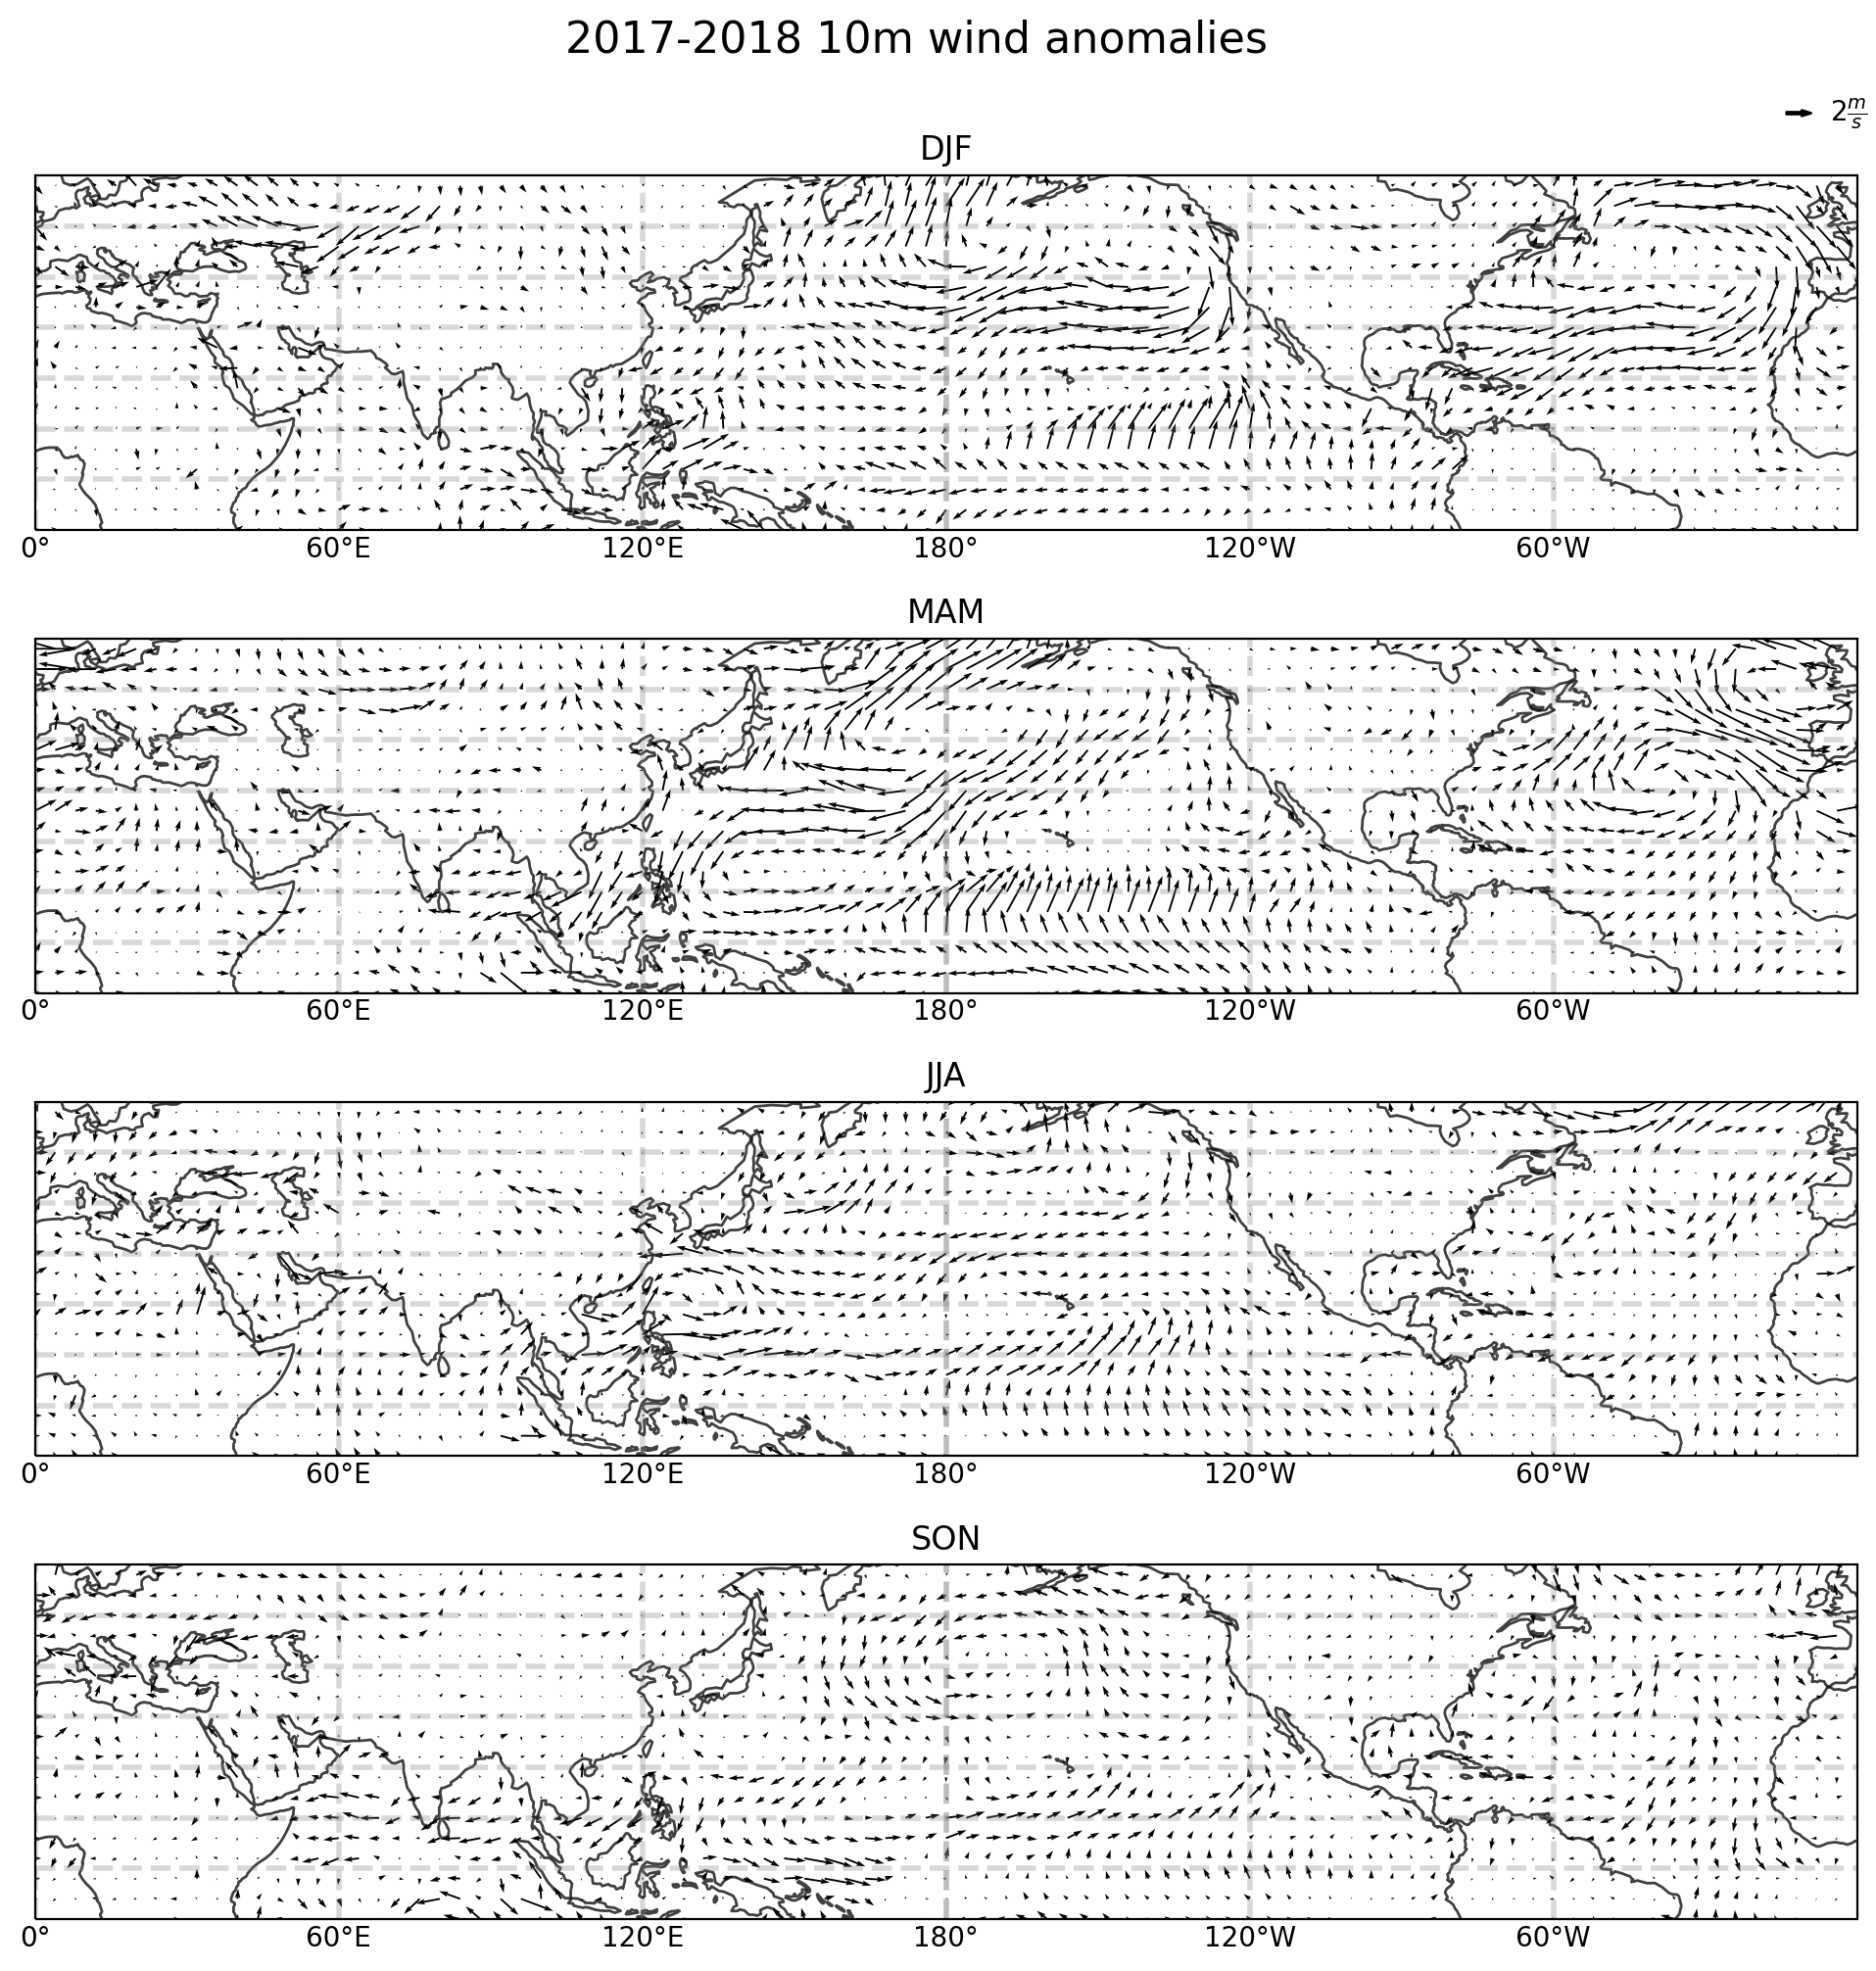

In [180]:
fig, ax = plt.subplots(4,1,figsize=(12,12),dpi=200)
extent = [0, 359, -10, 60]
u_plt = (anom_s.u10.sel(T=period).groupby('T.season').mean())
v_plt = (anom_s.v10.sel(T=period).groupby('T.season').mean())
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    qv = ax.quiver( x[::4], y[::4], u_plt.sel(season=seasons[i]).values[::4,::4], v_plt.sel(season=seasons[i]).values[::4,::4],width=1e-3, scale = 150, color='k',
                  transform=ccrs.PlateCarree())
    ax.coastlines(alpha=0.75)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.88, 0.9 , 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='k',linewidth=1)

plt.suptitle('2017-2018 10m wind anomalies',fontsize=16, y=0.94);


/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


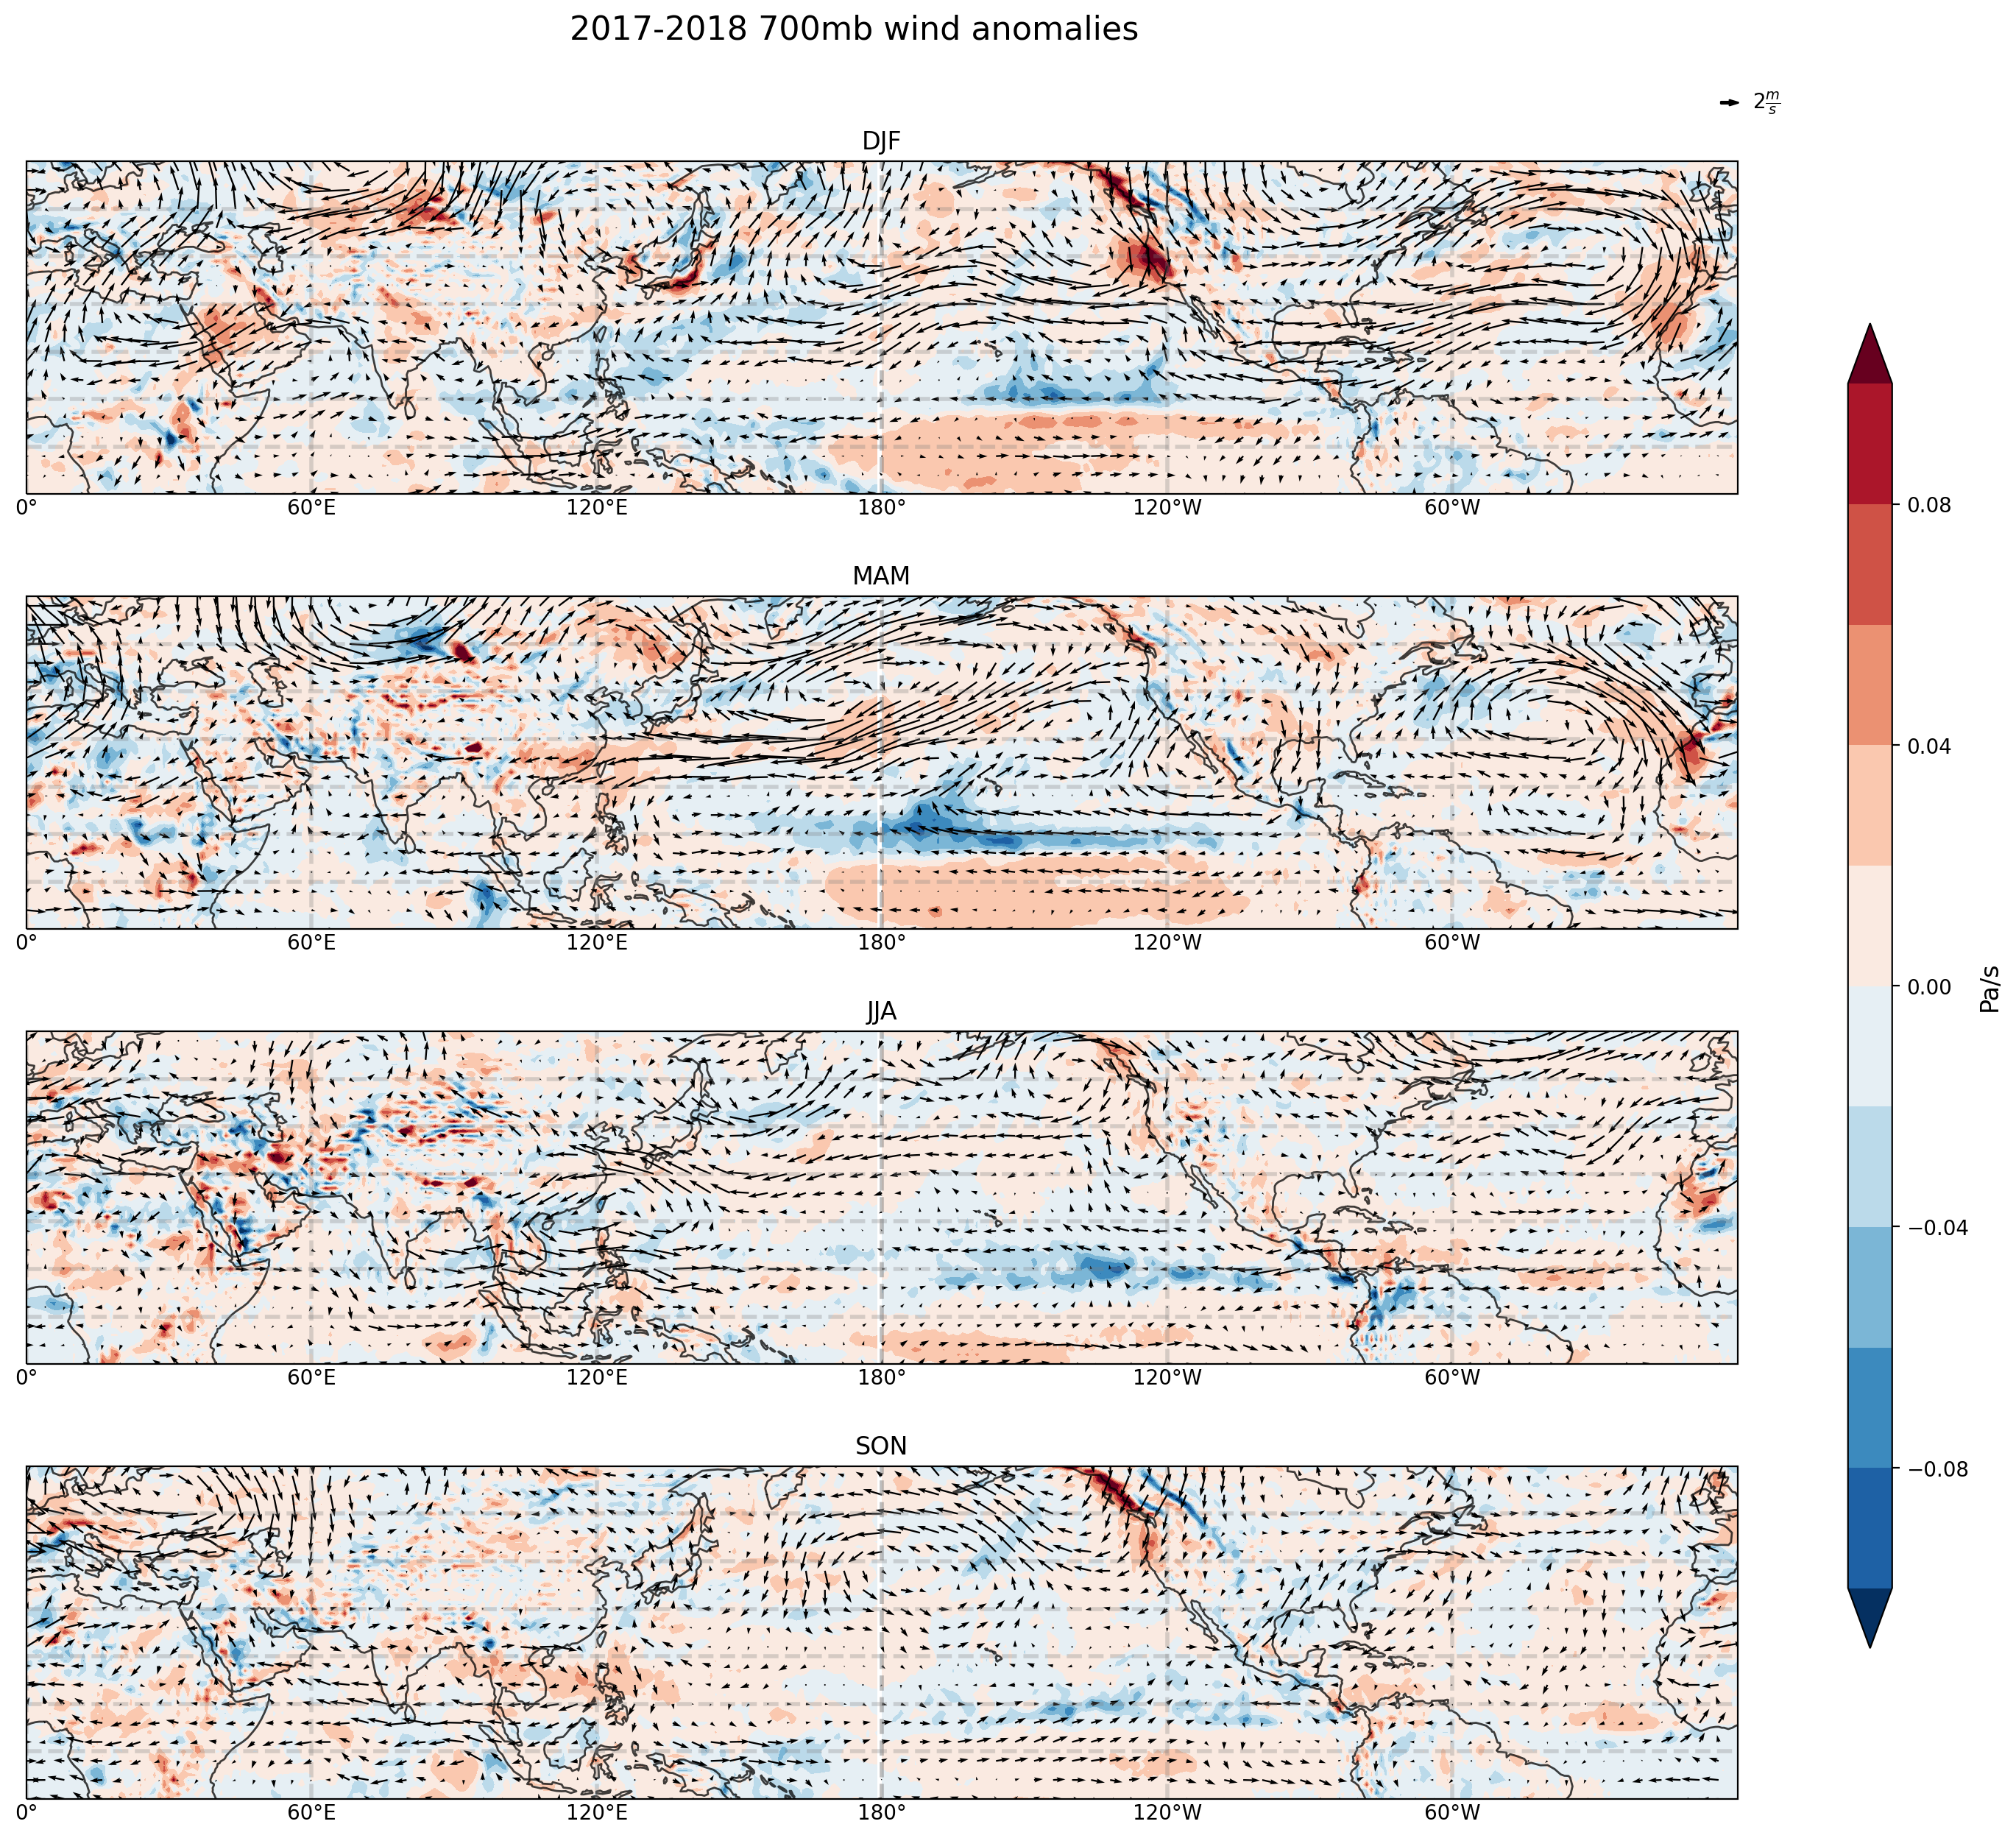

In [178]:
fig, ax = plt.subplots(4,1,figsize=(15,15),dpi=200)
extent = [0, 359, -10, 60]
u_plt = (anom_s.u700.sel(T=period).groupby('T.season').mean())
v_plt = (anom_s.v700.sel(T=period).groupby('T.season').mean())
x = u_plt.lon.values
y = u_plt.lat.values

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.w700.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-0.1, vmax = .1, levels=11, cmap='RdBu_r',add_colorbar=False, transform=ccrs.PlateCarree())
    qv = ax.quiver( x[::4], y[::4], u_plt.sel(season=seasons[i]).values[::4,::4], v_plt.sel(season=seasons[i]).values[::4,::4],width=1e-3, scale = 200, color='k',
                  transform=ccrs.PlateCarree())
    ax.coastlines(alpha=0.75)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    if i==0:
        ax.quiverkey(qv, 0.9, 0.9 , 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure',color='k',linewidth=1)

ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='Pa/s',size=12)
plt.suptitle('2017-2018 700mb wind anomalies',fontsize=16, y=0.94);


## SST

/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Fall2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


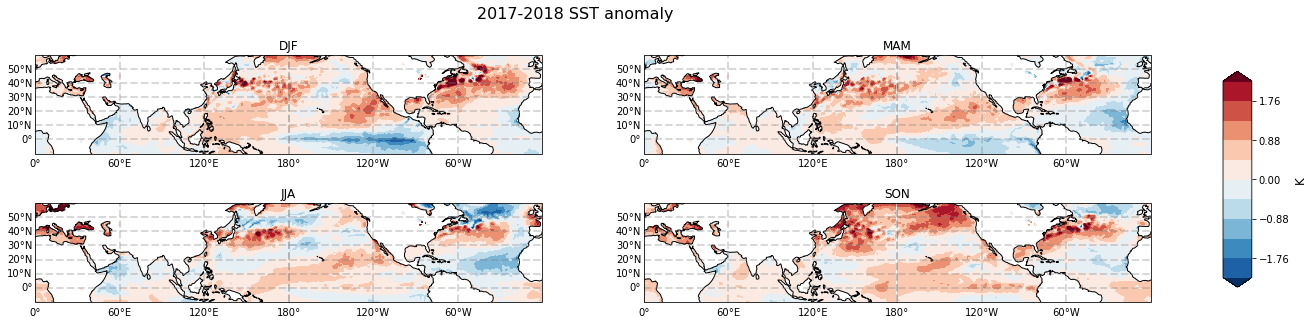

In [181]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.sst.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, vmin=-2.2, vmax=2.2,levels=11, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='K',size=12)
plt.suptitle('2017-2018 SST anomaly',fontsize=16);

DJF was a La Nina winter that weakens in the spring and is gone by the summer. 

## 200 mb geopotential height

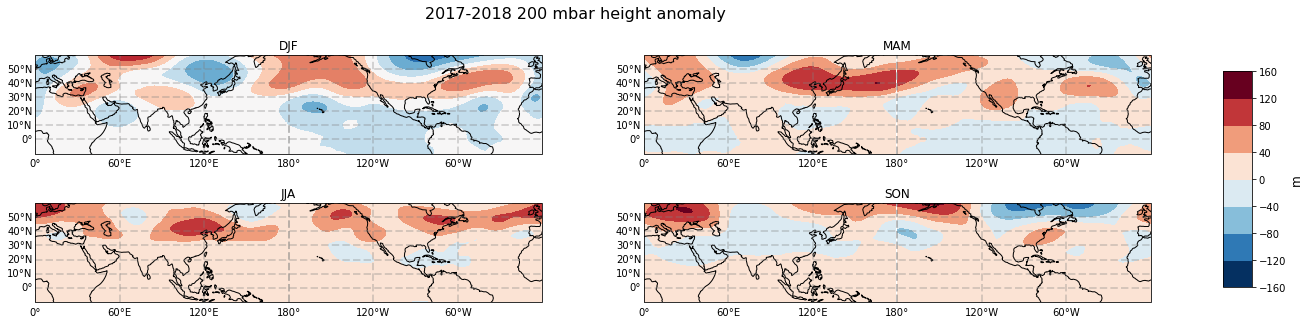

In [310]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = anom_s.z200.sel(T=period).groupby('season').mean().sel(season=seasons[i]).plot.contourf(
        ax=ax, levels=9, vmax=160, vmin=-160, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m',size=12)
plt.suptitle('2017-2018 200 mbar height anomaly',fontsize=16);

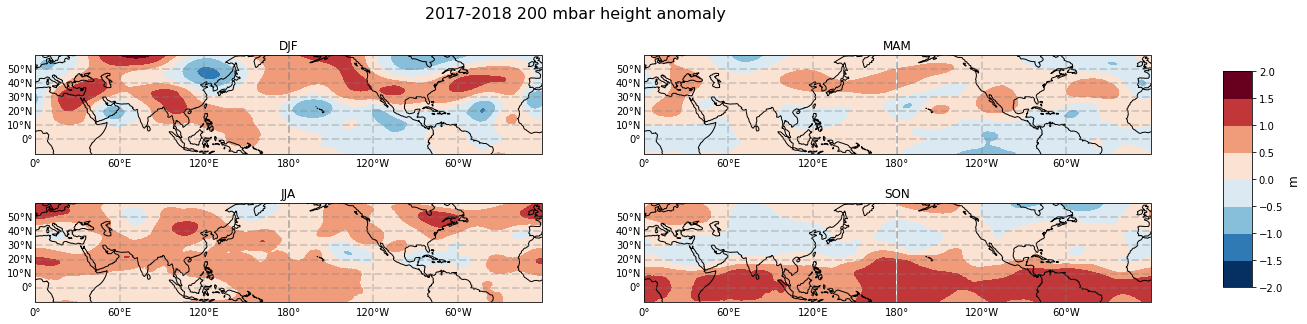

In [376]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
extent = [0, 359, -10, 60]

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = (anom_s.z200.sel(T=period).groupby('season').mean()/std_s.z200).sel(season=seasons[i]).plot.contourf(
        ax=ax, levels=9, vmax=2, vmin=-2, cmap='RdBu_r',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(seasons[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='m',size=12)
plt.suptitle('2017-2018 200 mbar height anomaly',fontsize=16);

# California burned area

In [412]:
# make pandas dataframe for a nice seaborn boxplot
df = burn_cali.drop('spatial_ref').to_dataframe()
df['month'] = df.index.month

## Timeseries and monthly climatology

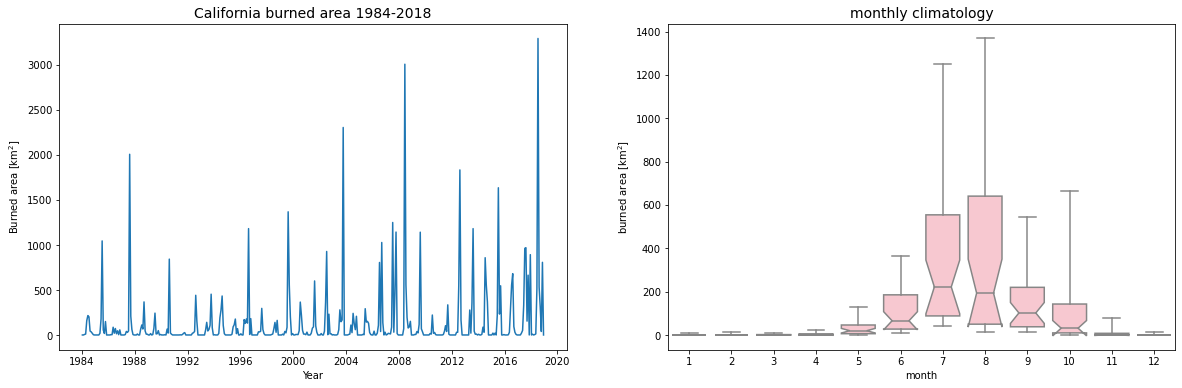

In [413]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(burn_cali.time,burn_cali.burnarea)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Burned area [km$^2$]')
ax[0].set_title('California burned area 1984-2018',fontsize=14);


sns.boxplot(data = df, x='month', y='burnarea',color='pink', showfliers=False, notch=True, whis=(5.,95.),ax=ax[1])
ax[1].set_title('monthly climatology',fontsize=14)
ax[1].set_ylabel('burned area [km$^2$]');

The whiskers in the box plot extend to the 5th and 95th percentiles of each month. July and August have the most burned area.

## Monthly trends

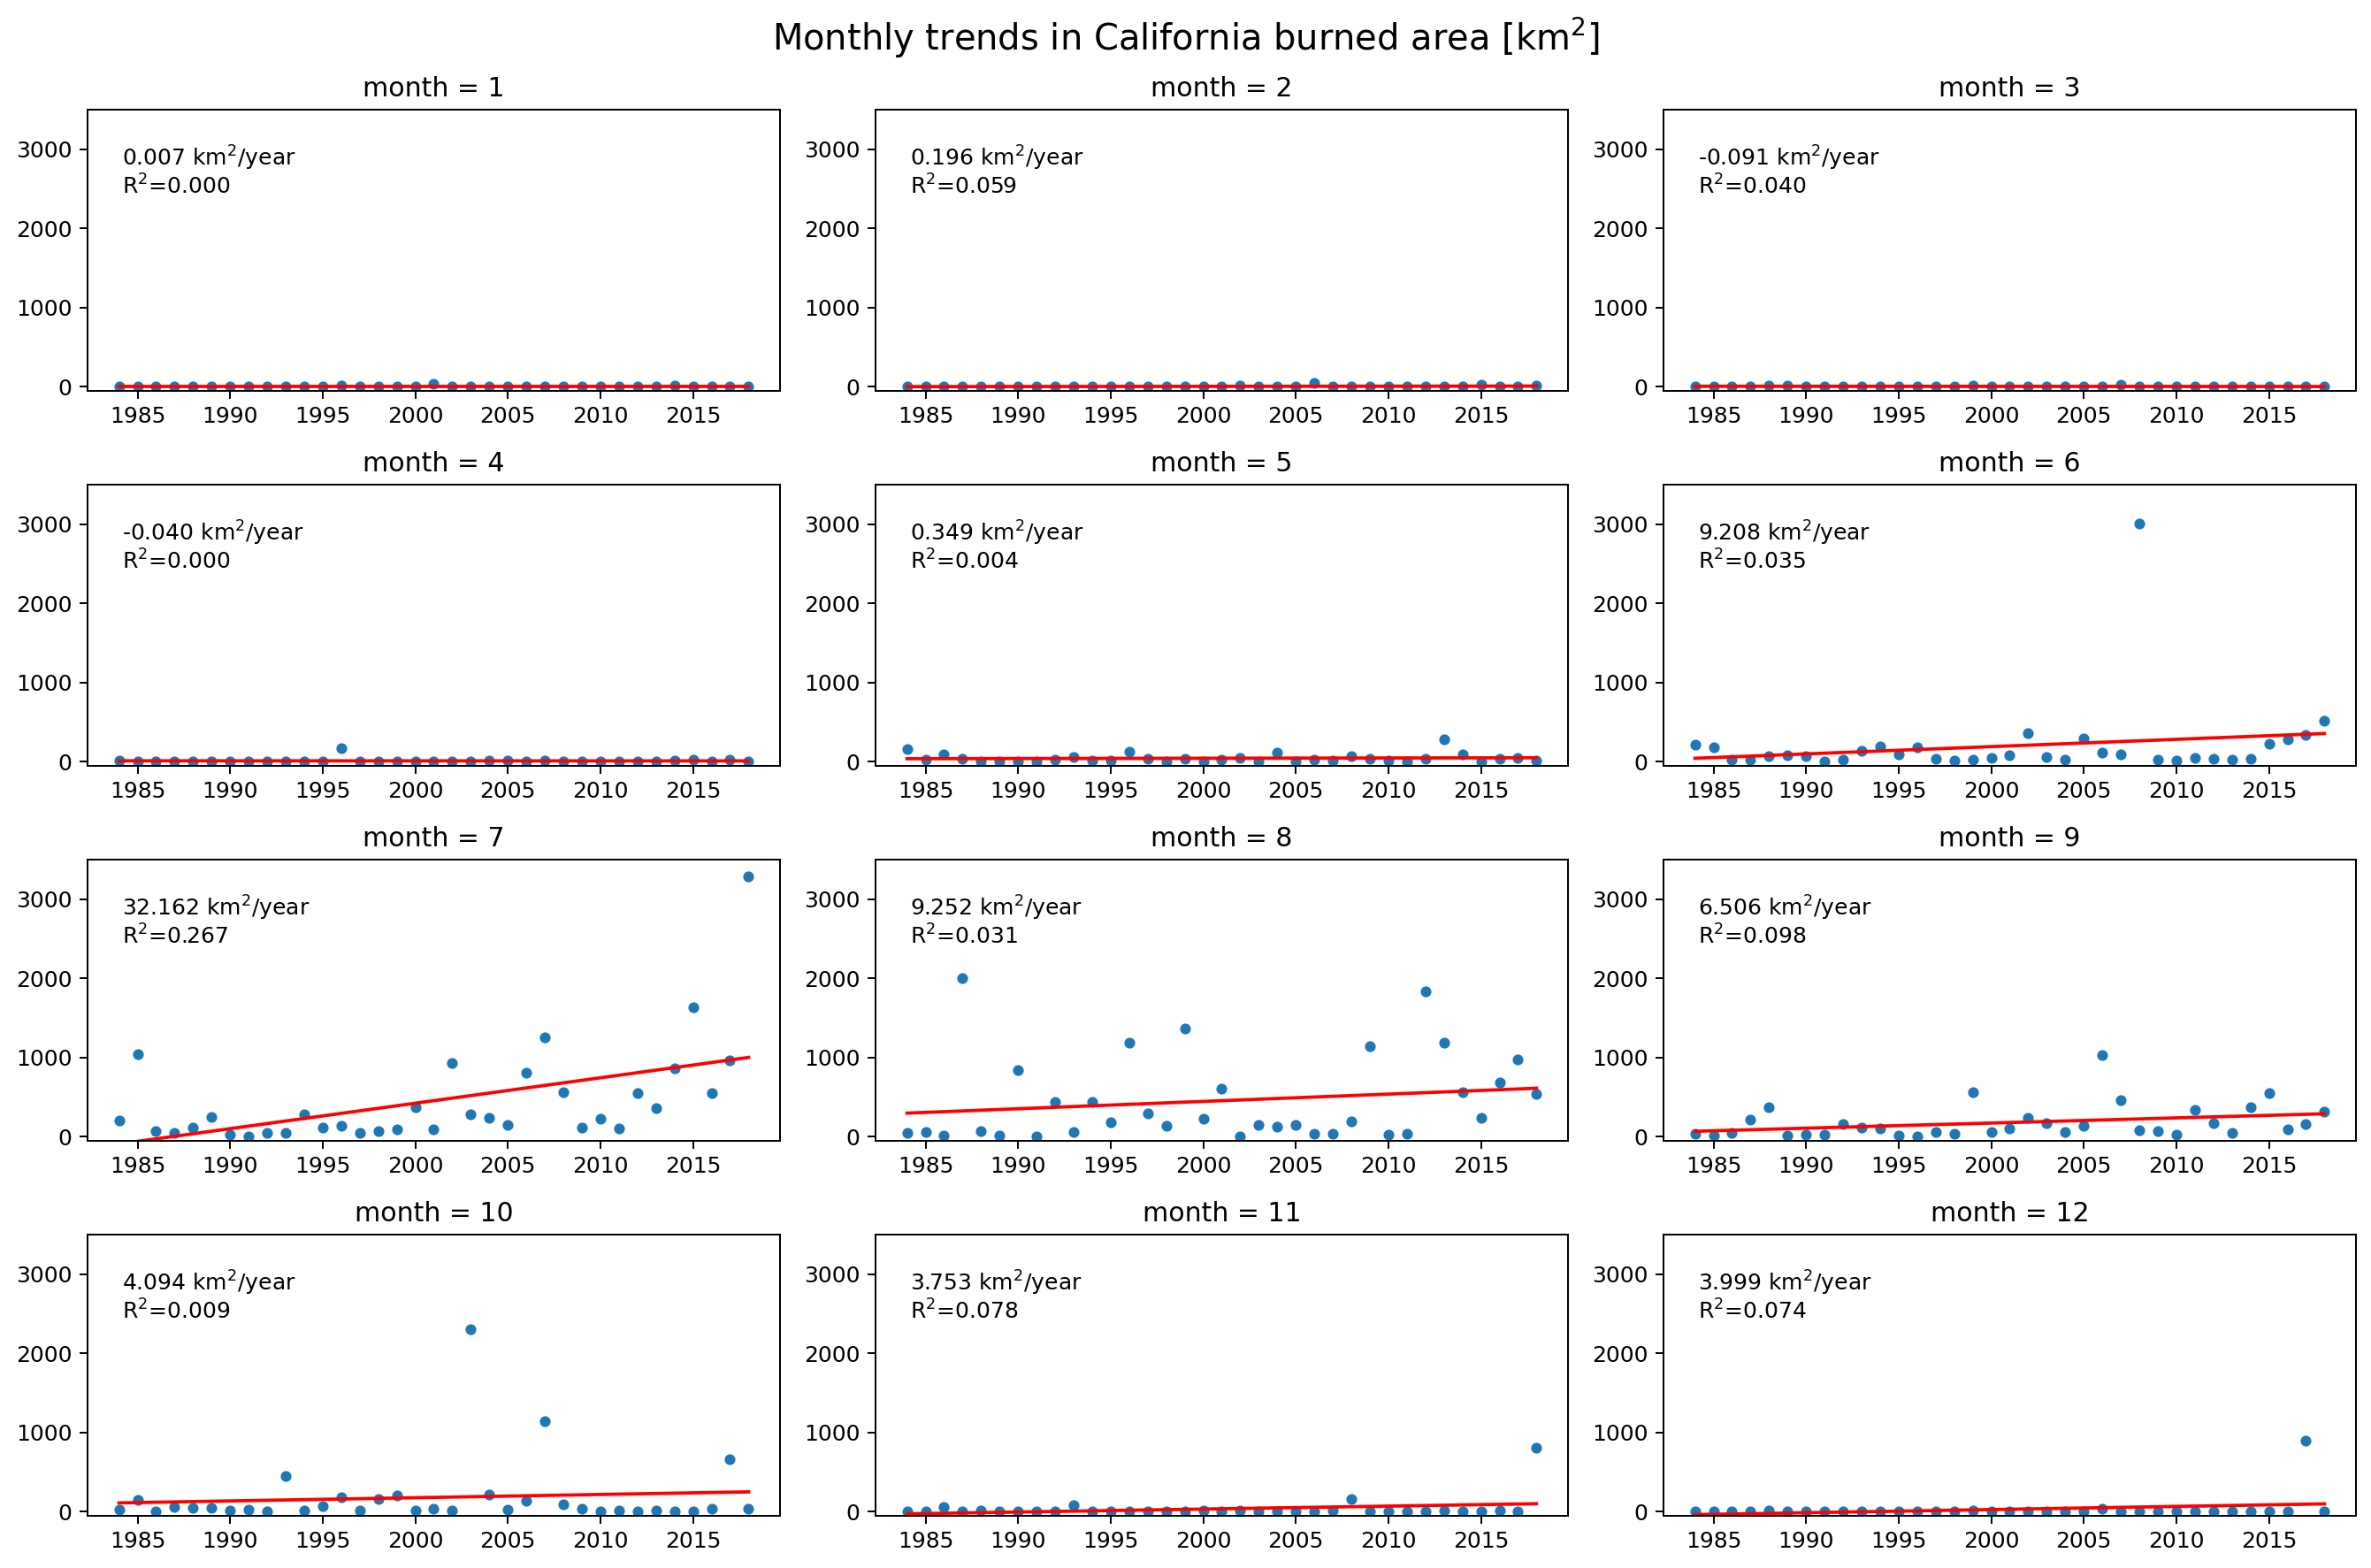

In [255]:
fig, ax = plt.subplots(4,3,figsize=(15,10),dpi=180,sharex=True)
burn_cali_m = burn_cali.groupby('time.month')
idxs = burn_cali_m.groups

for i, ax in enumerate(ax.flatten()):
    month_idxs = idxs[1+i]
    ds_burn=burn_cali.isel(time=month_idxs).groupby('time.year').mean()
    slope = ds_burn.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
    intercept = ds_burn.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
    fit = [slope * i + intercept for i in ds_burn.year]
    resid = ds_burn.polyfit('year',1,full=True).burnarea_polyfit_residuals
    r2 = 1 - (resid / (ds_burn.year.size * ds_burn.burnarea.var('year')))
    ax = plt.subplot(4,3,i+1)
    ax.text(0.05, 0.8,s=f'%.3f km$^2$/year'%slope.item(),transform=ax.transAxes)
    ax.text(0.05, 0.7,s=f'R$^2$=%.3f'%r2.item(),transform=ax.transAxes)
    ax.plot(ds_burn.year,fit,c='r')
    ax.scatter(ds_burn.year, ds_burn.burnarea,s=15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-50,3500])
    ax.set_title(f'month = {i+1}')
    ax.plot

plt.suptitle('Monthly trends in California burned area [km$^2$]', fontsize=16)
plt.tight_layout()

## Regress height anomalies onto August burn area

First, we detrend the August burned area timeseries to avoid correlating with the trend.

In [257]:
# detrend August timeseries
ds_m8=burn_cali.isel(time=idxs[8]).groupby('time.year').mean()
slope = ds_m8.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
intercept = ds_m8.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
fit = [slope * i + intercept for i in ds_burn.year]
ds_m8_detrend = ds_m8 - fit

In [187]:
# use scipy stats functions to use in xarray apply_ufunc
# have to do this to correlate one timeseries (July burn) with the timeseries at each gridpoint (DJF 200mbar height anomaly)
def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(slope)

def rval(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return xr.DataArray(r_value)

### August 200mbar z, august burn

Text(0.5, 0.98, 'Linear regression of August 200mb height anomaly with detrended August Cali burn area, 1984 - 2018')

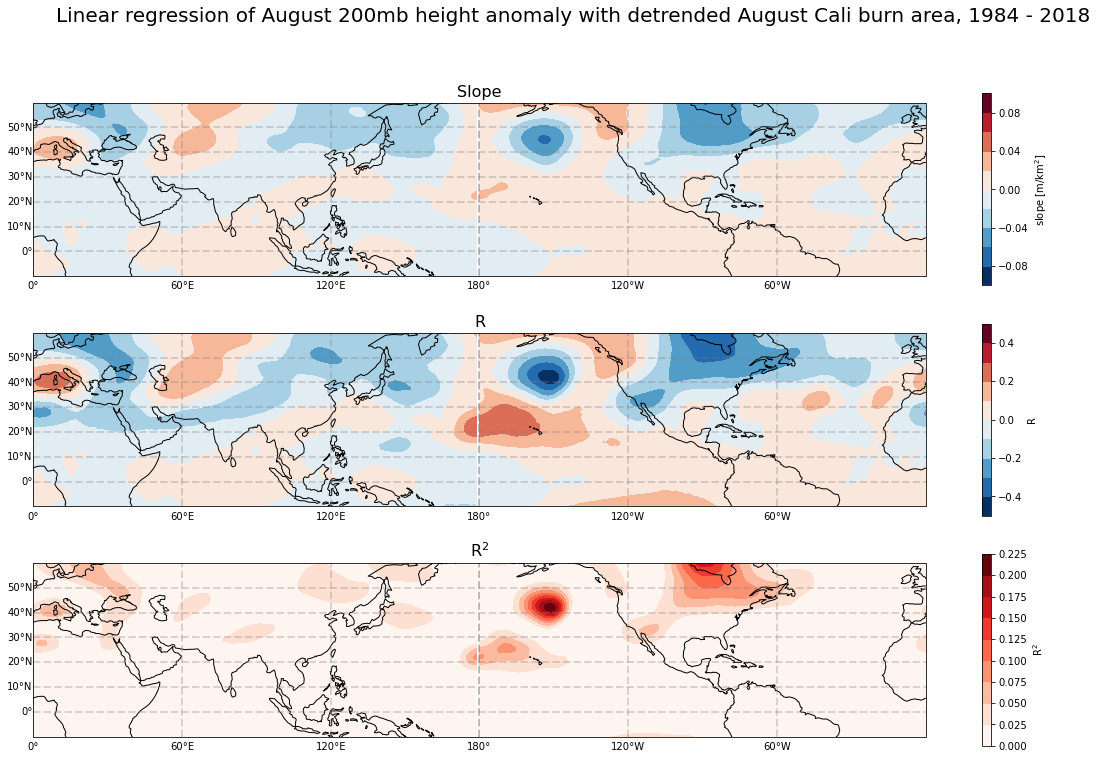

In [427]:
z200_fit = anom_m.z200.sel(T=slice('1984-01-15','2018-12-16')).isel(T=idxs[8]).groupby('T.year').mean()
z200_burn_fit = xr.merge([z200_fit,ds_m8_detrend])
slopes = xr.apply_ufunc(linear_trend, z200_burn_fit.burnarea, z200_burn_fit.z200, vectorize=True, input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

r = xr.apply_ufunc(rval, z200_burn_fit.burnarea, z200_burn_fit.z200, vectorize=True, input_core_dims=[['year'], ['year']],# reduce along 'year'
                        )

plt.subplots(3,1,figsize=(20,12))
extent = [0, 359, -10, 60]

ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = slopes.plot.contourf(ax=ax, levels=11, cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'slope [m/km$^2$]'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('Slope',fontsize=16)

ax1 = plt.subplot(3,1,3,projection=ccrs.PlateCarree(central_longitude=180))
im = (r**2).plot.contourf(ax=ax1, levels=11, cmap='Reds',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1, 'label':'R$^2$'})
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_extent(extent)    
ax1.set_title('R$^2$',fontsize=16)

ax2 = plt.subplot(3,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z200,dim='year').plot.contourf(ax=ax2, levels=11, cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('R',fontsize=16)

plt.suptitle('Linear regression of August 200mb height anomaly with detrended August Cali burn area, 1984 - 2018',fontsize=20)

### Preceding seasons 200mbar z, August burn

In [202]:
# do the regression
season_idxs = anom_m.sel(T=slice('1983-12-15','2018-11-16')).groupby('T.season').groups

# DJF
z200_fit = anom_m.z200.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['DJF']).resample({'T':'AS-DEC'}).mean().groupby('T.year').mean()
z200_fit = z200_fit.assign_coords(year = z200_fit.year + 1).sel(year=slice(1984,2018))
z200_burn_fit_DJF = xr.merge([z200_fit,ds_m8_detrend])
r_DJF = xr.apply_ufunc(rval, z200_burn_fit_DJF.burnarea, z200_burn_fit_DJF.z200, vectorize=True, input_core_dims=[['year'], ['year']])

# MAM
z200_fit = anom_m.z200.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['MAM']).resample({'T':'AS-MAR'}).mean().groupby('T.year').mean()
z200_burn_fit_MAM = xr.merge([z200_fit,ds_m8_detrend])
r_MAM = xr.apply_ufunc(rval, z200_burn_fit_MAM.burnarea, z200_burn_fit_MAM.z200, vectorize=True, input_core_dims=[['year'], ['year']])

# JJA
z200_fit = anom_m.z200.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['JJA']).resample({'T':'AS-JUN'}).mean().groupby('T.year').mean()
z200_burn_fit_JJA = xr.merge([z200_fit,ds_m8_detrend])
r_JJA = xr.apply_ufunc(rval, z200_burn_fit_JJA.burnarea, z200_burn_fit_JJA.z200, vectorize=True, input_core_dims=[['year'], ['year']])


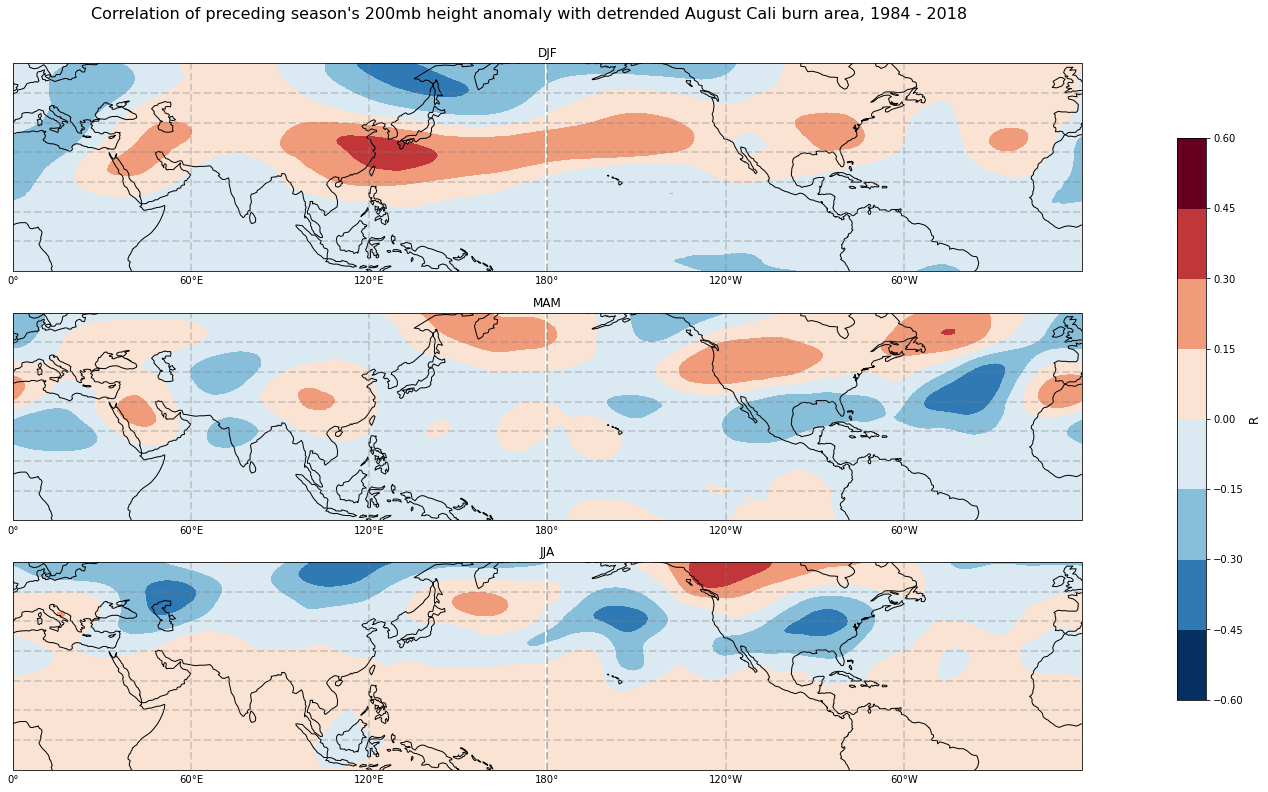

In [213]:
fig, ax = plt.subplots(3,1,figsize=(20,13))
extent = [0, 359, -10, 60]

dacorrs = [z200_burn_fit_DJF,z200_burn_fit_MAM, z200_burn_fit_JJA]
titles = ['DJF','MAM','JJA']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(3,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = xr.corr(dacorrs[i].burnarea, dacorrs[i].z200,dim='year').plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(titles[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='R',size=12)
plt.suptitle("Correlation of preceding season's 200mb height anomaly with detrended August Cali burn area, 1984 - 2018",fontsize=16,y=.94);


## Regress height anomalies onto July burn area

In [674]:
# detrend July timeseries
ds_m7=burn_cali.isel(time=idxs[7]).groupby('time.year').mean()
slope = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=1)
intercept = ds_m7.polyfit(dim='year',deg=1).burnarea_polyfit_coefficients.sel(degree=0)
fit = [slope * i + intercept for i in ds_burn.year]
ds_m7_detrend = ds_m7 - fit

In [675]:
# do the regression
# NDJ
month_idxs = anom_m.sel(T=slice('1983-11-15','2018-10-16')).groupby('T.month').groups
ndj_idxs = sorted(month_idxs[11] + month_idxs[12] + month_idxs[1])
z200_fit = anom_m.z200.sel(T=slice('1983-11-15','2018-10-16')).isel(T=ndj_idxs).resample({'T':'AS-NOV'}).mean().groupby('T.year').mean()
z200_fit = z200_fit.assign_coords(year = z200_fit.year + 1).sel(year=slice(1984,2018))
z200_burn_fit_NDJ = xr.merge([z200_fit,ds_m7_detrend])
r_NDJ = xr.apply_ufunc(rval, z200_burn_fit_NDJ.burnarea, z200_burn_fit_NDJ.z200, vectorize=True, input_core_dims=[['year'], ['year']])

# FMA
fma_idxs = sorted(month_idxs[2] + month_idxs[3] + month_idxs[4])
z200_fit = anom_m.z200.sel(T=slice('1983-11-15','2018-10-16')).isel(T=fma_idxs).resample({'T':'AS-FEB'}).mean().groupby('T.year').mean()
z200_burn_fit_FMA = xr.merge([z200_fit,ds_m7_detrend])
r_FMA = xr.apply_ufunc(rval, z200_burn_fit_FMA.burnarea, z200_burn_fit_FMA.z200, vectorize=True, input_core_dims=[['year'], ['year']])

# MJJ
mjj_idxs = sorted(month_idxs[5] + month_idxs[6] + month_idxs[7])
z200_fit = anom_m.z200.sel(T=slice('1983-11-15','2018-10-16')).isel(T=mjj_idxs).resample({'T':'AS-MAY'}).mean().groupby('T.year').mean()
z200_burn_fit_MJJ = xr.merge([z200_fit,ds_m7_detrend])
r_MJJ = xr.apply_ufunc(rval, z200_burn_fit_MJJ.burnarea, z200_burn_fit_MJJ.z200, vectorize=True, input_core_dims=[['year'], ['year']])

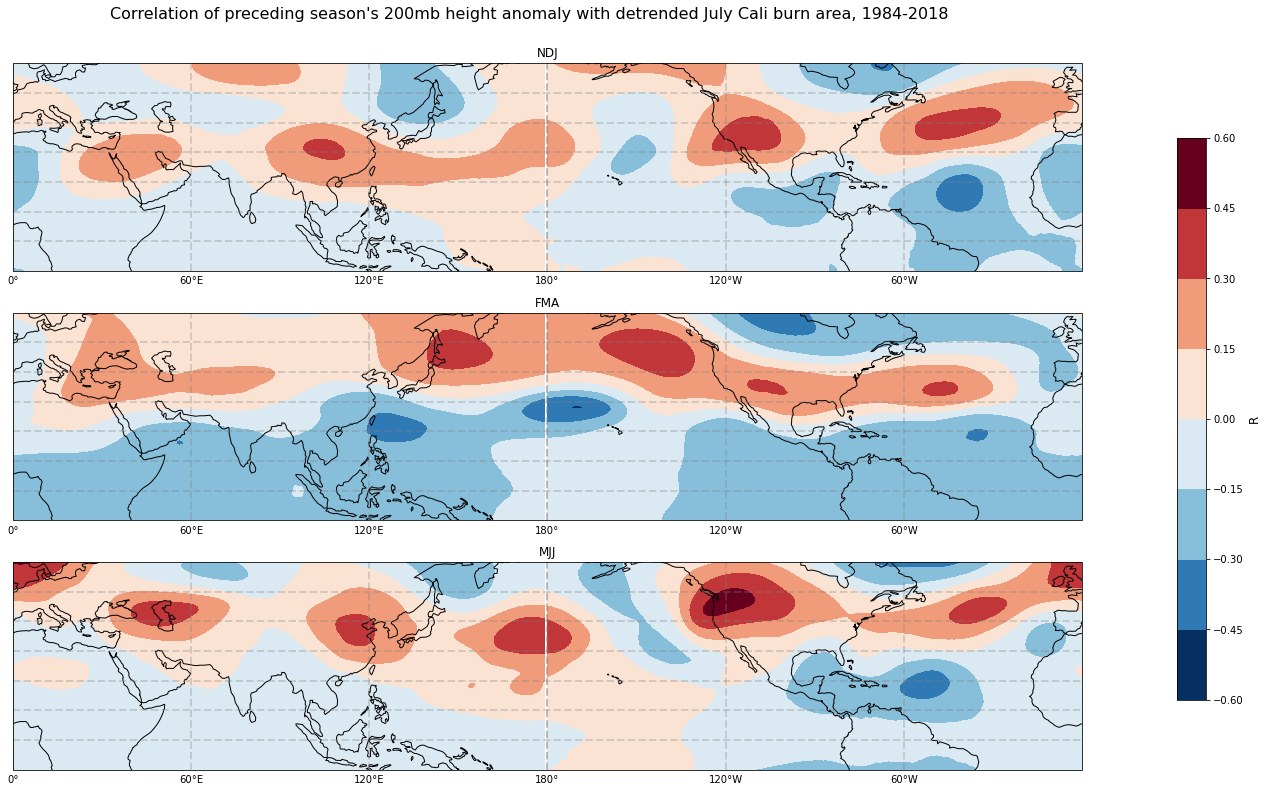

In [676]:
fig, ax = plt.subplots(3,1,figsize=(20,13))
extent = [0, 359, -10, 60]

dacorrs = [z200_burn_fit_NDJ,z200_burn_fit_FMA, z200_burn_fit_MJJ]
titles = ['NDJ','FMA','MJJ']

for i, ax in enumerate(ax.flatten()):
    ax = plt.subplot(3,1,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    im = xr.corr(dacorrs[i].burnarea, dacorrs[i].z200,dim='year').plot.contourf(ax=ax, levels=9, cmap='RdBu_r',vmax=0.6,vmin=-0.6,transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent)
    ax.set_title(titles[i])
    
ax = fig.add_axes((.95,.2,.02,.6))
plt.colorbar(im,cax=ax,orientation='vertical').set_label(label='R',size=12)
plt.suptitle("Correlation of preceding season's 200mb height anomaly with detrended July Cali burn area, 1984-2018",fontsize=16,y=.94);


## DJF 200 mbar height with July burn

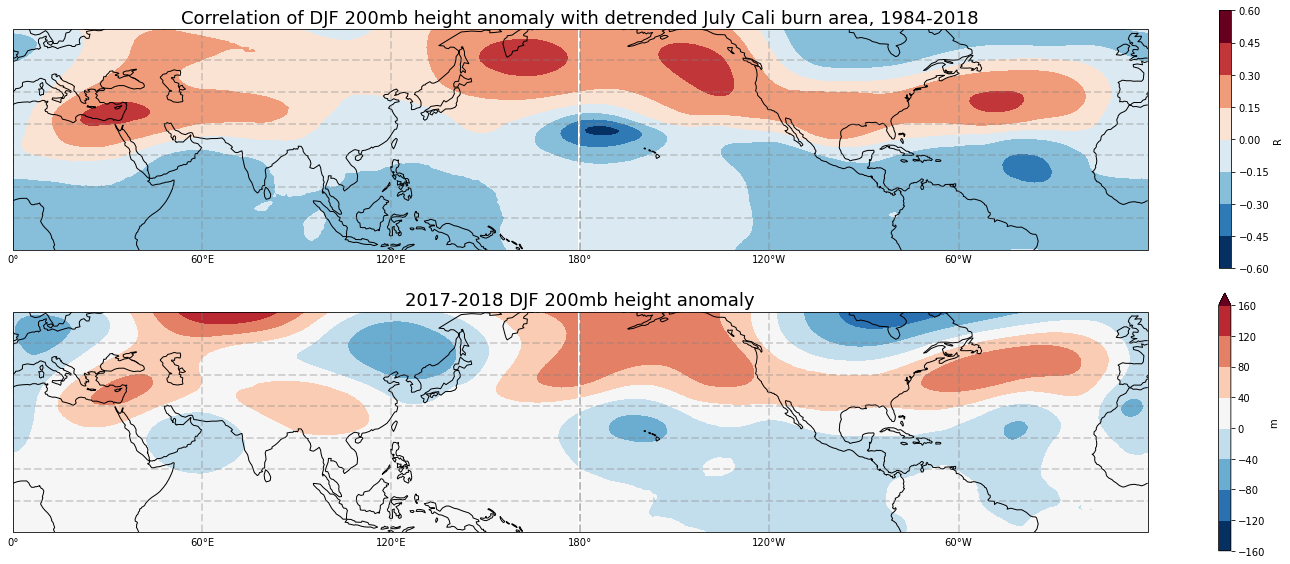

In [313]:
plt.subplots(2,1,figsize=(20,8))
extent = [0, 359, -10, 60]

season_idxs = anom_m.sel(T=slice('1983-12-15','2018-11-16')).groupby('T.season').groups
z200_fit = anom_m.z200.sel(T=slice('1983-12-15','2018-11-16')).isel(T=season_idxs['DJF']).resample({'T':'AS-DEC'}).mean().groupby('T.year').mean()
z200_fit = z200_fit.assign_coords(year = z200_fit.year + 1).sel(year=slice(1984,2018))
z200_burn_fit = xr.merge([z200_fit,ds_m7_detrend])

ax2 = plt.subplot(2,1,1,projection=ccrs.PlateCarree(central_longitude=180))
im = xr.corr(z200_burn_fit.burnarea, z200_burn_fit.z200,dim='year').plot.contourf(ax=ax2, levels=9, cmap='RdBu_r',vmax=0.6,transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'R'})
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_extent(extent)    
ax2.set_title('Correlation of DJF 200mb height anomaly with detrended July Cali burn area, 1984-2018',fontsize=18)

ax = plt.subplot(2,1,2,projection=ccrs.PlateCarree(central_longitude=180))
im = anom_s.z200.sel(T=period).groupby('season').mean().sel(season='DJF').plot.contourf(ax=ax, levels=9, vmax=160,cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':1,'label':'m'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent(extent)    
ax.set_title('2017-2018 DJF 200mb height anomaly',fontsize=18)

plt.tight_layout()